# Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('sberbank.csv') # renamed from the csv file within train.csv.zip on Kaggle

numeric_cols = df.select_dtypes(include=['number']).columns
print(numeric_cols)

non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

Index(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=276)
Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')


## 4. Irregular data (outliers)

Outliers are data that is distinct from other observations. They could bias our data analysis results, providing a misleading representation of the data. Outliers could be real outliers or mistakes.

### How to find out?

The definition of outliers is broadly defined for numeric data only. So let’s focus on methods of spotting outliers of numeric columns.

### Method 1: descriptive statistics

First, let’s look at kurtosis. Kurtosis is a statistical measure of ‘tailedness’. The higher kurtosis is often linked to the greater extremity of deviations (or outliers) in the data. So this is a single statistic to detect potential outliers.

In [2]:
df.kurt(numeric_only=True)[:10]

id               -1.199940
full_sq       12128.727462
life_sq       17058.409645
floor             1.731182
max_floor         6.595262
material          1.358512
build_year    16865.716093
num_room         13.292374
kitch_sq       4680.043742
state            88.399730
dtype: float64

Among the first 10 columns, we can see that life_sq has the highest kurtosis value. 

But note that the high value of kurtosis doesn’t guarantee outliers. So we should investigate this column more. For example, we could use the *describe* method in Python.

In [3]:
df['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

For the column life_sq, we can see that the maximum value is 7,478, while the 75th percentile is only 43. The maximum value is an outlier.

What if you want to learn more about the outliers? Let’s go-to method 2.

### Method 2: histogram & box plot
Let’s use the data visualization method to detect outliers. We’ll plot a histogram and a box plot of the column life_sq.

<Axes: >

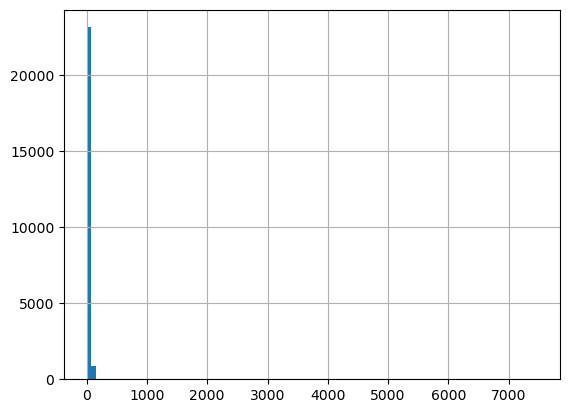

In [4]:
df['life_sq'].hist(bins=100)

<Axes: >

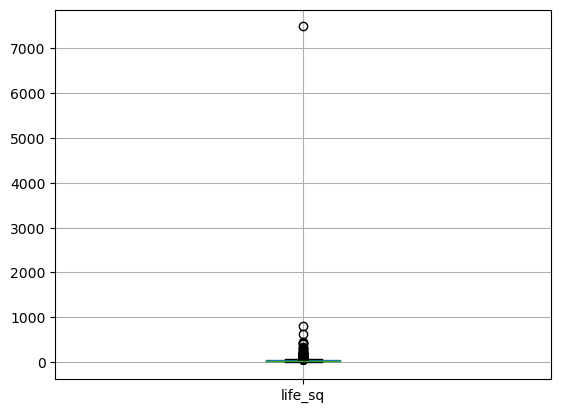

In [5]:
df.boxplot(column=['life_sq'])

From the box plot, we get a more clear view of the outliers. There is an outlier with a value of over 7,000. In fact, all the dots on the plot are considered outliers by the box plot definition.

<Axes: >

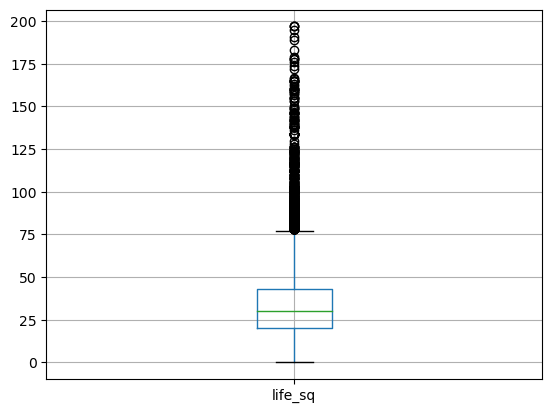

In [6]:
df[df['life_sq'] < 200].boxplot(column=['life_sq'])

### Method 3: IQR score 
Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

In [7]:
Q1 = df['life_sq'].quantile(0.25)
Q3 = df['life_sq'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

23.0


In [8]:
outlier =(df['life_sq'] < (Q1 - 1.5 * IQR)) |(df['life_sq'] > (Q3 + 1.5 * IQR))
outlier

0        False
1        False
2        False
3        False
4        False
         ...  
30466    False
30467    False
30468    False
30469    False
30470    False
Name: life_sq, Length: 30471, dtype: bool

In [9]:
outlier.value_counts()

False    29721
True       750
Name: life_sq, dtype: int64

### Method 4: bar chart
As mentioned, outliers are mainly defined for numeric data. But for non-numeric data, there could be irregular values too. We can use a bar chart to learn about the categories and their distributions.

For example, the column ecology has a reasonable distribution. But if there is a category with only one value called ‘extraordinary’, that could be considered an ‘outlier’.

<Axes: >

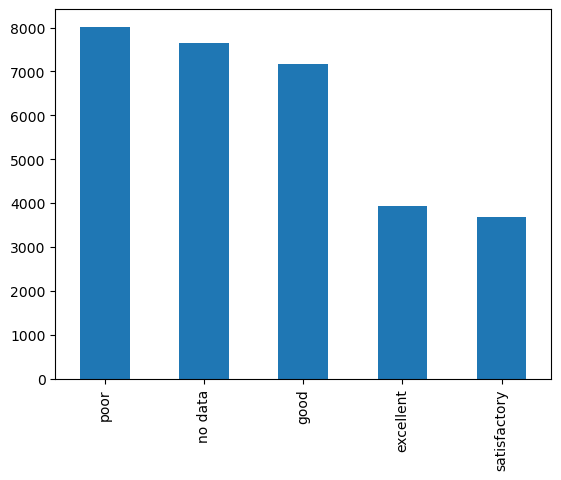

In [10]:
df['ecology'].value_counts().plot(kind='bar')

### Remove Outlier

While outliers are not hard to see, it is tricky to clean them. It depends on the dataset and the goal of the project.

The methods of handling outliers are somewhat similar to missing data. We could drop, replace, or even just keep them. Here we show how to remove outliers based on the IQR values.

In [11]:
life_sq_out = df['life_sq'][~((df['life_sq'] < (Q1 - 1.5 * IQR)) |(df['life_sq'] > (Q3 + 1.5 * IQR)))]
life_sq_out

0        27.0
1        19.0
2        29.0
3        50.0
4        77.0
         ... 
30466    27.0
30467    59.0
30468     NaN
30469    32.0
30470    28.0
Name: life_sq, Length: 29721, dtype: float64

<Axes: >

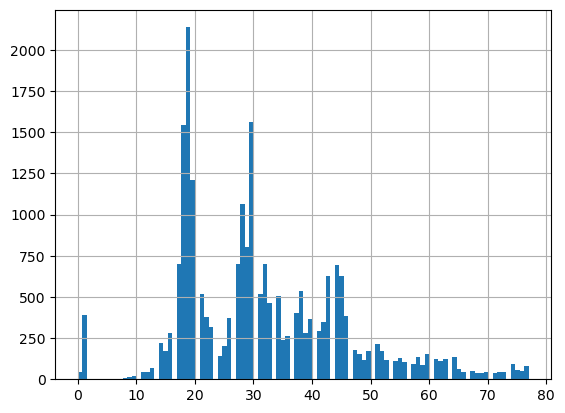

In [12]:
life_sq_out.hist(bins=100)

## 5. Unnecessary data

All the data included in the analysis should support the project’s goal. We consider the data to be unnecessary when it doesn’t add value. We’ll cover 3 main types of unnecessary data.

### Unnecessary type 1: repetitive & uninformative
One column can have many observations being the same value. When an extremely high percentage of the column has a repetitive value, we should investigate whether such a column provides valuable information.

How to find out?
We can generate a list of columns with a high percentage of the same value. For example, we specify below to show columns with over 99.9% rows being the same value.


In [13]:
num_rows = len(df)

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.9999:
        print('{0}: {1:.2f}%'.format(col, top_pct*100))
        print(cnts)
        print()

If there is one column with a high percentage of the same value, we should look into it to see if it’s informative. We can drop them when they are not, e.g., when the column has 100% being the same value.

### Unnecessary type 2: duplicates
The duplicate data is when copies of the same observation exist. Let’s look at 2 main types of duplicate data and clean them in Python.

**Duplicates type 1: all columns based**

This is easy to understand. Such duplicate occurs when all the columns’ values within the observations are the same.

We can use the *duplicated* method to grab the boolean values of whether a row is duplicated, and then use it to filter for duplicated rows from df.

In [14]:
df[df.duplicated()]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc


If there were any duplicates, we could remove them. We can use the *drop_duplicates* method. But this will return the same DataFrame since there weren’t any duplicates.

In [15]:
df.drop_duplicates()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,8/20/2011,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,8/23/2011,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,8/27/2011,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,9/1/2011,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,9/5/2011,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,6/30/2015,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,...,15,5,0,15,26,1,2,84,6,7400000
30467,30470,6/30/2015,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,313,128,24,98,182,1,82,171,15,25000000
30468,30471,6/30/2015,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,...,1,1,0,2,12,0,1,11,1,6970959
30469,30472,6/30/2015,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,22,1,1,6,31,1,4,65,7,13500000


**Duplicates type #2: key columns based**

Instead of looking at all columns, sometimes we want to detect duplicates based on a set of identifiers (columns).

For example, we know that the column id is probably unique. What if we drop it and see if there are duplicates based on the rest of the columns?

We first drop id, and then see if there are duplicated rows from the DataFrame.

In [16]:
df[df.drop(columns=['id']).duplicated()]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
3359,3362,8/27/2012,59,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,4,2,0,3,15,1,0,24,4,4506800
4328,4331,10/22/2012,61,NaN,18.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,5,4,0,1,32,5,8248500
6991,6994,4/3/2013,42,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,3,2,0,2,16,1,0,20,4,3444000
8059,8062,5/22/2013,68,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,3,2,0,2,16,1,0,20,4,5406690
8653,8656,6/24/2013,40,NaN,12.0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,4,1,4112800
14004,14007,1/22/2014,46,28.0,1.0,9.0,1.0,1968.0,2.0,5.0,...,10,1,0,13,15,1,1,61,4,3000000
17404,17407,4/15/2014,134,134.0,1.0,1.0,1.0,0.0,3.0,0.0,...,0,0,0,0,1,0,0,0,0,5798496
26675,26678,12/17/2014,62,NaN,9.0,17.0,1.0,NaN,2.0,1.0,...,371,141,26,150,249,2,105,203,13,6552000
28361,28364,3/14/2015,62,NaN,2.0,17.0,1.0,NaN,2.0,1.0,...,371,141,26,150,249,2,105,203,13,6520500
28712,28715,3/30/2015,41,41.0,11.0,17.0,1.0,2016.0,1.0,41.0,...,2,2,0,2,9,0,0,7,2,4114580


In [17]:
df_dedupped = df.drop(columns=['id']).drop_duplicates()

print(df.shape)
print(df_dedupped.shape)

(30471, 292)
(30461, 291)


For house sales, let’s assume that if two transactions have the same timestamp, full_sq, life_sq, floor, build_year, num_room, price_doc, they are duplicates. Let’s look at duplicates based on this set of columns. We can use the below code to show the duplicated rows based on those columns.

In [18]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year', 'num_room', 'price_doc']

df_grouped = df.fillna(-999).groupby(key)['id'].count()

df_grouped[df_grouped > 1]

timestamp   full_sq  life_sq  floor  build_year  num_room  price_doc
1/22/2014   46        28.0    1.0     1968.0      2.0      3000000      2
10/22/2012  61       -999.0   18.0   -999.0      -999.0    8248500      2
12/17/2014  62       -999.0   9.0    -999.0       2.0      6552000      2
12/18/2013  39       -999.0   6.0    -999.0       1.0      3700946      2
12/5/2013   40       -999.0   5.0    -999.0       1.0      4414080      2
12/9/2014   40       -999.0   17.0   -999.0       1.0      4607265      2
3/14/2015   62       -999.0   2.0    -999.0       2.0      6520500      2
3/30/2015   41        41.0    11.0    2016.0      1.0      4114580      2
4/15/2014   134       134.0   1.0     0.0         3.0      5798496      2
4/3/2013    42       -999.0   2.0    -999.0      -999.0    3444000      2
5/22/2013   68       -999.0   2.0    -999.0      -999.0    5406690      2
6/24/2013   40       -999.0   12.0   -999.0      -999.0    4112800      2
8/27/2012   59       -999.0   6.0    -999.0

In [19]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year', 'num_room', 'price_doc']
df_dedupped2 = df.drop_duplicates(subset=key)

print(df.shape)
print(df_dedupped2.shape)

(30471, 292)
(30455, 292)


## 6. Inconsistent data
It is crucial to have the dataset follow specific standards. There could be different inconsistent data that needs to be cleaned and we’ll cover 4 common ones. Please note that the actual data may be even messier, be creative when cleaning it!

### Inconsistent type #1: capitalization
Inconsistent use of upper and lower cases in categorical values is typical. We need to clean it since Python is case-sensitive.

Let’s look at *sub_area*, which stores the name of different areas.

In [20]:
df['sub_area'].value_counts(dropna=False)

Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: sub_area, Length: 146, dtype: int64

We are lucky that the text in this column looks standardized. But there could be inconsistent capitalizations. For instance, ‘Poselenie Sosenskoe’ and ‘pOseleNie sosenskeo’ could refer to the same district.

To avoid this, we can lowercase (or uppercase) all letters.

In [21]:
df['sub_area_lower'] = df['sub_area'].str.lower()
df['sub_area_lower'].value_counts(dropna=False)

poselenie sosenskoe               1776
nekrasovka                        1611
poselenie vnukovskoe              1372
poselenie moskovskij               925
poselenie voskresenskoe            713
                                  ... 
molzhaninovskoe                      3
poselenie shhapovskoe                2
poselenie kievskij                   2
poselenie klenovskoe                 1
poselenie mihajlovo-jarcevskoe       1
Name: sub_area_lower, Length: 146, dtype: int64

### Inconsistent type 2: typos of categorical values

A categorical column takes on a limited and usually fixed number of possible values. Sometimes it shows other values due to reasons like typos.

Let’s see an example. Within the code below:

- We generate a new DataFrame, df_city_ex
- There is only one column that stores the city names. There are misspellings. For example, ‘torontoo’ and ‘tronto’ both refer to the city of ‘toronto’.
- The variable cities stores the 4 correct names of ‘toronto’, ‘vancouver’, ‘montreal’, and ‘calgary’.
- To identify typos, we use fuzzy logic matches. We use edit_distance from nltk, which measures the number of operations (e.g., substitution, insertion, deletion) needed to change from one string into another string.
- We calculate the distance between the actual values and the correct values.

In [22]:
df_city_ex = pd.DataFrame(data={'city': ['torontoo', 'toronto', 'tronto', 'vancouver', 'vancover', 'vancouvr', 'montreal', 'calgary']})

cities = ['toronto', 'vancouver', 'montreal', 'calgary']
from nltk.metrics import edit_distance
for city in cities:
    df_city_ex[f'city_distance_{city}'] = df_city_ex['city'].map(lambda x: edit_distance(x, city))

df_city_ex

,city,city_distance_toronto,city_distance_vancouver,city_distance_montreal,city_distance_calgary
0,torontoo,1,8,7,8
1,toronto,0,8,7,7
2,tronto,1,8,6,7
3,vancouver,8,0,8,8
4,vancover,7,1,7,7
5,vancouvr,7,1,7,7
6,montreal,7,8,0,8
7,calgary,7,8,8,0


We can set criteria to convert these typos to the correct values. For example, the below code sets all the values within 2 characters distance from ‘toronto’/’vancouver’ to be ‘toronto’/’vancouver’.

In [23]:
msk = df_city_ex['city_distance_toronto'] <= 2
df_city_ex.loc[msk, 'city'] = 'toronto'

msk = df_city_ex['city_distance_vancouver'] <= 2
df_city_ex.loc[msk, 'city'] = 'vancouver'

df_city_ex

,city,city_distance_toronto,city_distance_vancouver,city_distance_montreal,city_distance_calgary
0,toronto,1,8,7,8
1,toronto,0,8,7,7
2,toronto,1,8,6,7
3,vancouver,8,0,8,8
4,vancouver,7,1,7,7
5,vancouver,7,1,7,7
6,montreal,7,8,0,8
7,calgary,7,8,8,0


### Inconsistent type 3: addresses

If you’ve worked with addresses, you know how messy they can be. Just imagine how people can write addresses in all different ways!

We can find messy address data by looking at it. Even though sometimes we can’t spot any problems, we can still run code to standardize them in case there are hidden issues.

There is no address column in our housing dataset due to privacy. Let’s create a new dataset df_add_ex with a column address.

In [25]:
df_add_ex = pd.DataFrame(['123 MAIN St Apartment 15', '123 Main Street Apt 12   ', '543 FirSt Av', '  876 FIRst Ave.'], columns=['address'])
df_add_ex

,address
0,123 MAIN St Apartment 15
1,123 Main Street Apt 12
2,543 FirSt Av
3,876 FIRst Ave.


We can run the below code to:

- lowercase the letters
- remove leading and trailing white spaces
- delete periods
- standardize wordings

In [26]:
df_add_ex['address_std'] = df_add_ex['address'].str.lower()
df_add_ex['address_std'] = df_add_ex['address_std'].str.strip() # remove leading and trailing whitespaces.
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\.', '', regex=True) # remove period.
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bstreet\\b', 'st', regex=True) # replace street with st.
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bapartment\\b', 'apt', regex=True) # replace apartment with apt.
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('\\bav\\b', 'ave', regex=True) # replace av with ave.

df_add_ex

,address,address_std
0,123 MAIN St Apartment 15,123 main st apt 15
1,123 Main Street Apt 12,123 main st apt 12
2,543 FirSt Av,543 first ave
3,876 FIRst Ave.,876 first ave
